## Oil Imports

In [160]:
import requests
import pandas as pd
import matplotlib.pyplot as plt  
import os
import calendar

API key

In [161]:
API_KEY = os.environ.get("EIA_API_KEY")

if not API_KEY:
    raise ValueError("API key not found. Set the EIA_API_KEY environment variable.")

## Data retrived from https://www.eia.gov/opendata/

In [162]:
# API endpoint for monthly crude oil imports
url = "https://api.eia.gov/v2/crude-oil-imports/data/?frequency=monthly&data[0]=quantity&start=2023-01&end=2025-01&sort[0][column]=period&sort[0][direction]=asc&offset=0&length=5000"

# Parameters for the request
params = {
    "frequency": "monthly",
    "data[0]": "quantity",
    "start": "2020-01",
    "end": "2025-01",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "api_key": API_KEY
}

Request 

In [163]:
response = requests.get(url, params=params)

# Check if request was successful
if response.status_code == 200:
    data = response.json()
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(data['response']['data'])

else:
    print(f"Error fetching data: {response.status_code}")
    print(response.text)

## Initial inspection

In [164]:
print(df.head())  # First 5 rows

    period originId originName originType originTypeName destinationId  \
0  2025-01   CTY_KU     Kuwait        CTY        Country          PP_3   
1  2025-01   REG_AF     Africa        REG         Region         RS_HI   
2  2025-01   REG_AF     Africa        REG         Region         RS_NJ   
3  2025-01   REG_AF     Africa        REG         Region         RS_NJ   
4  2025-01   REG_AF     Africa        REG         Region       PT_1003   

      destinationName destinationType destinationTypeName gradeId  \
0  PADD3 (Gulf Coast)              PP           Port PADD     HSO   
1              Hawaii              RS      Refinery State     LSW   
2          New Jersey              RS      Refinery State     LSW   
3          New Jersey              RS      Refinery State     MED   
4          Newark, NJ              PT                Port     LSW   

     gradeName quantity    quantity-units  
0   Heavy Sour     1039  thousand barrels  
1  Light Sweet     1047  thousand barrels  
2  Light

In [165]:
print("\nData types:\n", df.dtypes)  # Check column types


Data types:
 period                 object
originId               object
originName             object
originType             object
originTypeName         object
destinationId          object
destinationName        object
destinationType        object
destinationTypeName    object
gradeId                object
gradeName              object
quantity               object
quantity-units         object
dtype: object


In [166]:
print("\nMissing values:\n", df.isnull().sum())  # Check for gaps


Missing values:
 period                 0
originId               0
originName             0
originType             0
originTypeName         0
destinationId          0
destinationName        0
destinationType        0
destinationTypeName    0
gradeId                0
gradeName              0
quantity               0
quantity-units         0
dtype: int64


In [167]:
print("\nTime period covered:", df['period'].min(), "to", df['period'].max()) #check for period range


Time period covered: 2024-11 to 2025-01


In [168]:
print("Duplicate rows:", df.duplicated().sum()) #check for duplicates

Duplicate rows: 0


In [169]:
print(df['period'].value_counts()) #counting values of period

period
2025-01    2140
2024-12    2140
2024-11     720
Name: count, dtype: int64


In [170]:
print(df['gradeName'].value_counts())

gradeName
Heavy Sour     1930
Medium         1433
Light Sweet     812
Light Sour      619
Heavy Sweet     206
Name: count, dtype: int64


Dealing with object type

In [171]:
# Remove any commas or special characters
df['quantity'] = df['quantity'].astype(str).str.replace(',', '')

# Convert to numeric, coercing errors
df['quantity'] = pd.to_numeric(df['quantity'], errors='coerce')

## Preparing data for plot

In [172]:
# Define the month you want to analyze (e.g., 12 for December)
month = 12  # Change this to any month (1-12)

# Convert month number to name (e.g., 12 → "December")
month_name = calendar.month_name[month]

In [173]:
# Filter for December (month 12) of any year
grade = df[df['period'].str.endswith(f'-{month:02d}')]  # e.g., "2023-12"

In [174]:
# Group by gradeName and sum the quantities
grade_totals = grade.groupby('gradeName')['quantity'].sum().reset_index()

# Sort by largest quantities first
grade_totals = grade_totals.sort_values('quantity', ascending=False)

print(grade_totals)

     gradeName  quantity
0   Heavy Sour   3596152
4       Medium   1508332
3  Light Sweet    336784
2   Light Sour    226856
1  Heavy Sweet     23576


In [175]:
print("\nQuantity min and max:", df['quantity'].min(), "to", df['quantity'].max())


Quantity min and max: 1 to 129719


In [176]:
print(df['quantity-units'].value_counts())

quantity-units
thousand barrels    5000
Name: count, dtype: int64


## Create bar plot

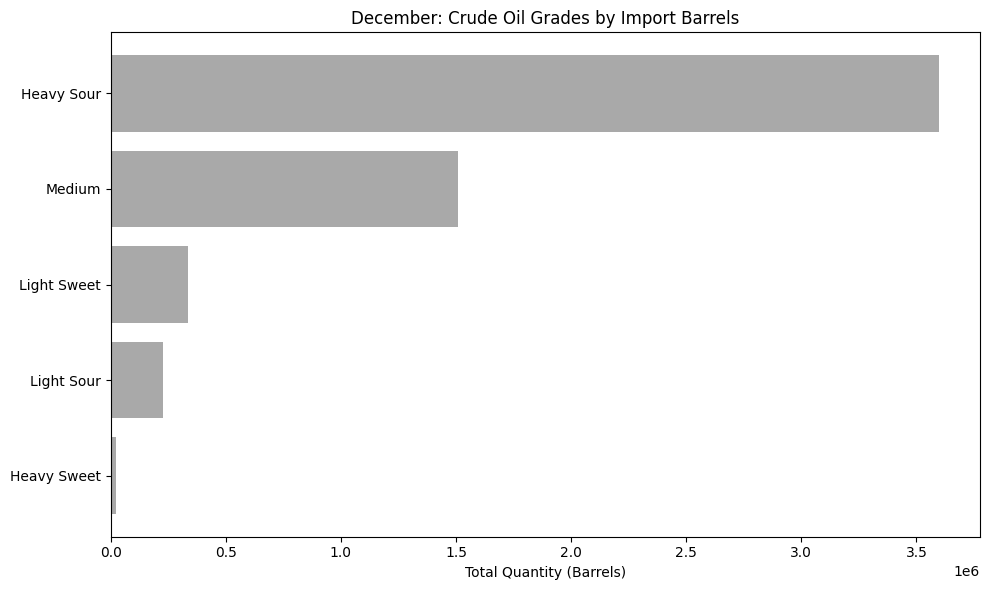

In [177]:
plt.figure(figsize=(10, 6))
plt.barh(grade_totals['gradeName'], grade_totals['quantity'], color='darkgray')
plt.xlabel('Total Quantity (Barrels)')
plt.title(f'{month_name}: Crude Oil Grades by Import Barrels')
plt.gca().invert_yaxis()  # Highest quantity at top
plt.tight_layout()
plt.show()

Preparing to plot other graph

In [178]:
print(df['originName'].value_counts())

originName
World                   860
Canada                  813
Non-OPEC                776
Canada (Region)         554
Other Americas          308
OPEC                    183
Mexico                  181
Brazil                  116
Middle East              96
Saudi Arabia             95
Colombia                 94
Venezuela                89
Iraq                     89
Argentina                87
Africa                   69
Trinidad and Tobago      68
Nigeria                  62
Angola                   49
Europe                   46
United Kingdom           46
Kazakhstan               43
Ecuador                  41
Libya                    39
Guyana                   35
Kuwait                   34
Eurasia                  32
United Arab Emirates     23
Ghana                    21
Algeria                  16
Norway                   14
Peru                      7
Guatemala                 7
Senegal                   7
Name: count, dtype: int64


Plot that shows the top 10 exportation places

In [179]:
# Group by 'originName' and sum 'quantity'
origin_quantity = grade.groupby('originName')['quantity'].sum().reset_index()

# Sort by quantity (descending)
origin_quantity = origin_quantity.sort_values('quantity', ascending=False)

In [180]:
origin_quantity = origin_quantity.head(10)  # Top 10 countries

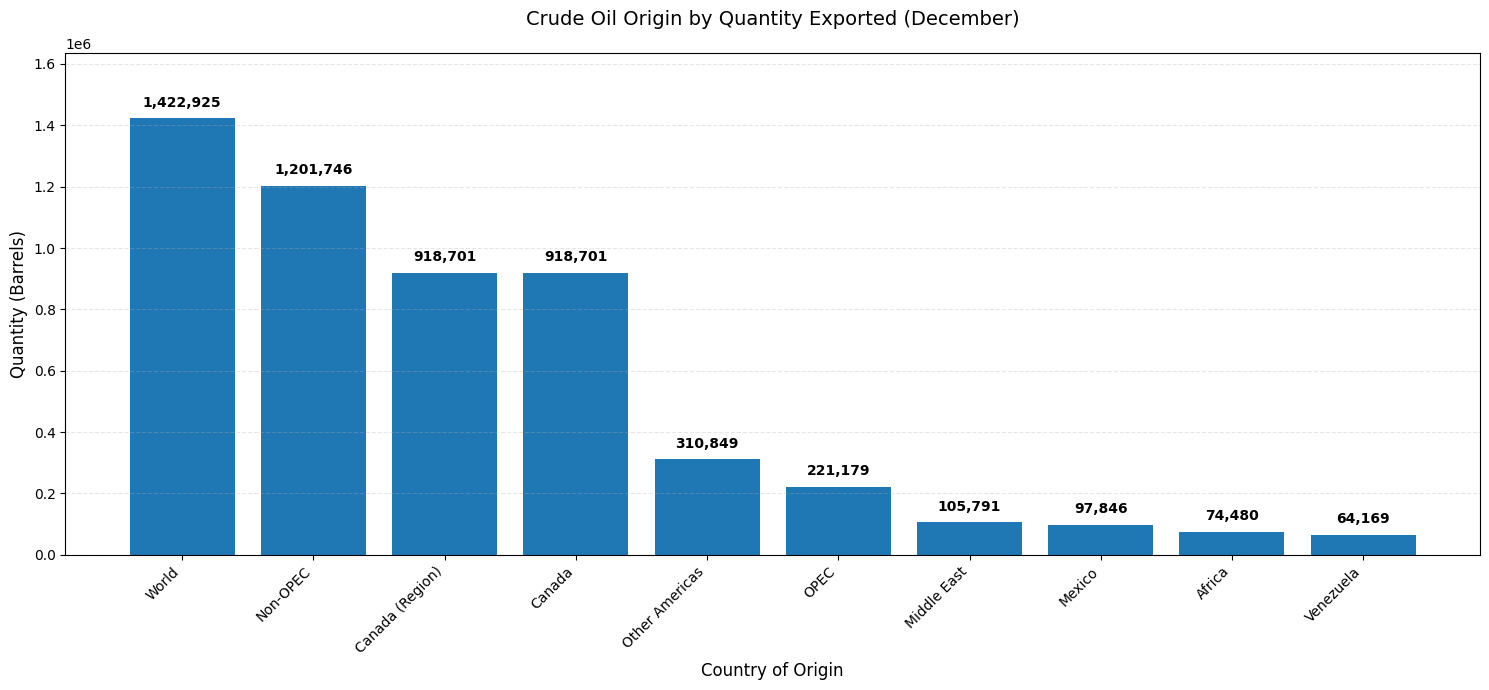

In [182]:
# Create the plot
plt.figure(figsize=(15, 7))
bars = plt.bar(origin_quantity['originName'], origin_quantity['quantity'], color='#1f77b4')

# Customize value labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x-position: center of the bar
        height + (0.02 * max(origin_quantity['quantity'])),  # y-position: slightly above the bar
        f'{height:,.0f}',  # Format with commas (e.g., 1,000,000)
        ha='center',       # Horizontal alignment
        va='bottom',       # Vertical alignment
        fontsize=10,
        fontweight='bold'
    )

# Adjust plot aesthetics
plt.xlabel('Country of Origin', fontsize=12)
plt.ylabel('Quantity (Barrels)', fontsize=12)
plt.title(f'Crude Oil Origin by Quantity Exported ({month_name})', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(origin_quantity['quantity']) * 1.15)  # Add headroom for labels

# Add grid and tighten layout
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()